<a href="https://colab.research.google.com/github/CharlesLclrc/TensorGAN/blob/main/notebooks/test_function_gan_architecture_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTS
#basics
from tensorflow.keras.layers import Input, Activation
#conv
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, MaxPooling2D, UpSampling2D  
#others
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from tensorflow import reduce_mean, ones_like,zeros_like
from tensorflow.math import square, abs
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
photos = image_dataset_from_directory(directory='/content/drive/MyDrive/photo/photo3', labels = None, batch_size=477,shuffle=None)
sketchs = image_dataset_from_directory(directory='/content/drive/MyDrive/sketch/sketch3', labels = None, batch_size=477,shuffle=None)

Found 478 files belonging to 1 classes.
Found 477 files belonging to 1 classes.


In [ ]:
X = [next(iter(photos)).numpy(),next(iter(sketchs)).numpy()]
y = next(iter(sketchs)).numpy()

In [ ]:
class Conv_bloc(Layer):

    """
    Conv_bloc for the encoder part of the generator. 
    
    Main parameters consists of:
    
    - filters: Integer, the dimensionality of the output space (i.e. the number 
    of output filters in the convolution).
    - kernel_size: An integer or tuple/list of 2 integers, specifying the height 
    and width of the 2D convolution window. Can be a single integer to specify 
    the same value for all spatial dimensions.
    - knl_init_stddev: RandomNormal argument stddev for kernel initialization 
    a python scalar or a scalar tensor. Standard deviation of the random values to generate.
    - batch_norm: boolean to apply BatchNormalization or not in the layer
    - max_pool: boolean to apply MaxPooling2D or not in the layer
    - max_pool_size: MaxPooling2D pool_size argument. Integer or tuple of 2 integers, 
    window size over which to take the maximum. 
    (2, 2) will take the max value over a 2x2 pooling window. 
    If only one integer is specified, the same window length will be used for both dimensions.
    - lk_relu_alpha: LeakyRelu is the activation layer for the Conv_bloc. 
    Alpha is a float >= 0. Negative slope coefficient. Default to 0.3.
    - drop_out_rate: default as None, so no Dropout is activated. 
    Else, float between 0 and 1. Fraction of the input units to drop.
    """

    def __init__(self, 
                 filters,
                 kernel_size = 3,
                 knl_init_stddev=0.2,
                 batch_norm = True,
                 max_pool=True,
                 max_pool_size= 2,
                 lk_relu_alpha=0.2,
                 drop_out_rate=None
                 ):

        super(Conv_bloc,self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.batch_norm = batch_norm
        self.max_pool=max_pool
        self.max_pool_size = max_pool_size
        self.knl_init_stddev=knl_init_stddev
        self.lk_relu_alpha=lk_relu_alpha
        self.drop_out_rate = drop_out_rate

        self.conv = Conv2D(filters = self.filters,
                           kernel_size = self.kernel_size,
                           padding = 'same',
                           kernel_initializer = RandomNormal(stddev= self.knl_init_stddev))
        self.batch_normalization = BatchNormalization()
        self.leakyrelu = LeakyReLU(alpha=self.lk_relu_alpha)
        self.max_pool2D = MaxPooling2D(pool_size=self.max_pool_size)
        self.dropout = Dropout(self.drop_out_rate)
        
    def call(self, input):

        # conv layer
        c = self.conv(input)
        
        # batch_norm
        if self.batch_norm: c = self.batch_normalization(c,training=False)
        c = self.leakyrelu(c)
        if self.drop_out_rate: c = self.dropout(c)
        conv = c 
        if self.max_pool: conv = self.max_pool2D(c)
        return conv, c

class Decod_bloc(Layer):
    def __init__(self, 
                 filters,
                 kernel_size = 3,
                 batch_norm = True,
                 max_pool=False,
                 max_pool_size= 2,
                 knl_init_stddev=0.2,
                 drop_out_rate=None):
        
        super(Decod_bloc,self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.batch_norm = batch_norm
        self.max_pool=max_pool
        self.max_pool_size = max_pool_size
        self.knl_init_stddev=knl_init_stddev
        self.drop_out_rate = drop_out_rate
        
        self.upsampling2D = UpSampling2D(size=self.max_pool_size)
        
        self.conv2DT = Conv2DTranspose(filters= self.filters, 
                        kernel_size= self.kernel_size, 
                        padding= 'same', 
                        kernel_initializer= RandomNormal(stddev= self.knl_init_stddev))
        
        self.batch_normalization = BatchNormalization()
        self.dropout = Dropout(self.drop_out_rate)
        self.concat = Concatenate(axis=-1)
        self.conv1 = Conv2D(filters = self.filters,
                  kernel_size = self.kernel_size,
                  padding = 'same',
                  kernel_initializer = RandomNormal(stddev= self.knl_init_stddev))
        self.conv2 = Conv2D(filters = self.filters,
                  kernel_size = self.kernel_size,
                  padding = 'same',
                  kernel_initializer = RandomNormal(stddev= self.knl_init_stddev))

        
    def call(self,input,skip_in):
        if self.max_pool: g = self.upsampling2D(input)
        g = self.conv2DT(input if not self.max_pool else g)
        if self.batch_norm: g = self.batch_normalization(g, training=False)
        g = self.concat([g, skip_in])
        g = self.conv1(g)
        g = Activation('relu')(g)
        g = self.conv2(g)
        g = Activation('relu')(g)
        if self.drop_out_rate: g = self.dropout(g, training=True)
        return g

In [ ]:
class Generator(Model):
    def __init__(self, 
                 kernel_size = 3,
                 batch_norm = True,
                 max_pool=True,
                 max_pool_size= 2,
                 knl_init_stddev=0.2,
                 lk_relu_alpha=0.2,
                 drop_out_rate=None,
                 **kwargs
                 ):
    
        super(Generator,self).__init__()

        #Conv_bloc & decoder kwargs
        self.kernel_size = kernel_size
        self.batch_norm = batch_norm
        self.max_pool=max_pool
        self.max_pool_size= max_pool_size
        self.knl_init_stddev=knl_init_stddev
        self.lk_relu_alpha=lk_relu_alpha
        self.drop_out_rate=drop_out_rate
        
        kwargs = dict(kernel_size = self.kernel_size, 
                        batch_norm = self.batch_norm,
                        max_pool = self.max_pool,
                        max_pool_size = self.max_pool_size,
                        knl_init_stddev = self.knl_init_stddev,
                        lk_relu_alpha = self.lk_relu_alpha,
                      drop_out_rate=self.drop_out_rate
                      )

        #Encoder

        self.e1 = Conv_bloc(32,**kwargs)
        self.e2 = Conv_bloc(64,**kwargs)
        self.e3 = Conv_bloc(128,**kwargs)
        self.e4 = Conv_bloc(256,**kwargs)
        self.e5 = Conv_bloc(512,**kwargs)
        self.bottleneck = Conv2D(512, 
                                 (4,4),  
                                 padding='same', 
                                 kernel_initializer=RandomNormal(stddev= self.knl_init_stddev))
        
        kwargs.pop('lk_relu_alpha')
        #Decoder
        self.d1 = Decod_bloc(512,**kwargs)
        self.d2 = Decod_bloc(256,**kwargs)
        self.d3 = Decod_bloc(128,**kwargs)
        self.d4 = Decod_bloc(64,**kwargs)
        self.d5 = Decod_bloc(32,**kwargs)
        self.g = Conv2DTranspose(3,
                        3,
                        padding='same', 
                        kernel_initializer=RandomNormal(stddev = self.knl_init_stddev))
        
    def call(self,input):

        conv, e1 = self.e1(input)
        conv, e2 = self.e2(conv)
        conv, e3 = self.e3(conv)
        conv, e4 = self.e4(conv)
        conv, e5 = self.e5(conv)

        b = self.bottleneck(conv)
        b = Activation('relu')(b)

        conv = self.d1(b, e5) 
        conv = self.d2(conv, e4) 
        conv = self.d3(conv, e3) 
        conv = self.d4(conv, e2) 
        conv = self.d5(conv, e1) 

        g = self.g(conv)
        out_image = Activation('sigmoid',name='generator')(g)

        return out_image

In [ ]:
  class Discriminator(Model):
    
    def __init__(self, 
                 kernel_size = (4,4),
                 batch_norm = True,
                 max_pool=True,
                 max_pool_size= 1,
                 knl_init_stddev=0.2,
                 lk_relu_alpha=0.2,
                 drop_out_rate=None,
                 **kwargs
                 ):
        super(Discriminator, self).__init__()
        
        #Conv_bloc kwargs
        self.kernel_size = kernel_size
        self.batch_norm = batch_norm
        self.max_pool = max_pool
        self.max_pool_size = max_pool_size
        self.knl_init_stddev = knl_init_stddev
        self.lk_relu_alpha = lk_relu_alpha
        self.drop_out_rate = drop_out_rate
        
        kwargs = dict(kernel_size = self.kernel_size, 
                      batch_norm = self.batch_norm,
                      max_pool = self.max_pool,
                      max_pool_size = self.max_pool_size,
                      knl_init_stddev = self.knl_init_stddev,
                      lk_relu_alpha = self.lk_relu_alpha,
                      drop_out_rate = drop_out_rate)
        
        # discriminator layers
        self.d1 = Conv_bloc(64,**kwargs)
        self.d2 = Conv_bloc(128,**kwargs)
        self.d3 = Conv_bloc(256,**kwargs)
        self.d4 = Conv_bloc(512,**kwargs)
        kwargs.pop('max_pool',None)
        self.d5 = Conv_bloc(512, max_pool=False ,**kwargs)
        # self.patch_out = Dense(1) 
        self.patch_out = Conv2D(1, 
                                (4,4), 
                                padding='same', 
                                kernel_initializer=RandomNormal(stddev=self.knl_init_stddev))
        self.concat = Concatenate(axis=0)
        self.concat_res = Concatenate(axis=-1)
        
    def call(self,pred_image,target_image):
        d1 = self.d1(pred_image)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        
        patch_out = self.patch_out(d5)
        discriminator_gen = Activation('sigmoid', name='discriminator')(patch_out)

        d1 = self.d1(target_image)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)

        patch_out = self.patch_out(d5)
        discriminator_real = Activation('sigmoid', name='discriminator')(patch_out)

        discriminators = self.concat_res([discriminator_gen, discriminator_real])

        return discriminators

In [ ]:
# input = Input(shape=(256,256,3))
# d = Generator()(input)
# output = Discriminator()(d,input)
# Model(input,output).summary()

In [ ]:
class Gan_loss(Loss):
    def __init__(self,coef=1):
        super().__init__()
        self.coef = coef
        
    def call(self, y_true, y_pred):
        mae_loss = reduce_mean(abs(y_pred - y_true), axis=-1)
        #sigmoid_cross_entropy = BinaryCrossentropy(from_logits=True)
        #sigmoid_cross_entropy = sigmoid_cross_entropy(ones_like(y_pred), y_pred)
        return self.coef*mae_loss# + sigmoid_cross_entropy

class Disc_loss(Loss):        
    def call(self, y_true, y_pred):
        y_gen = y_pred[:,:,0]
        y_real = y_pred[:,:,1]
        sigmoid_cross_entropy = BinaryCrossentropy(from_logits=True)
        gen_loss = sigmoid_cross_entropy(zeros_like(y_gen),y_gen)
        real_loss = sigmoid_cross_entropy(ones_like(y_real),y_real)
        total_loss = gen_loss + real_loss
        return total_loss

In [ ]:
def Pix2Pix(image_shape=(256,256,3)):
    
    discriminator1 = Discriminator()
    discriminator2 = Discriminator()
    generator = Generator()
    
    # for layer in discriminator1.layers:
    #     if not isinstance(layer, BatchNormalization):
    #         layer.trainable = False
    
    input_gen = Input(shape=image_shape)
    input_disc = Input(shape=image_shape)
    gen_out = generator(input_gen) 
    dis_out = discriminator1(gen_out,input_gen)
    
    model = Model(inputs=[input_gen, input_disc], outputs = [dis_out, gen_out])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.75)
    
    model.compile(loss={dis_out.name.split('/')[0]:Disc_loss(), 
                     gen_out.name.split('/')[0]:Gan_loss(1e-5)}, 
               optimizer=opt, 
               loss_weights=[1,1])
    
    return model

In [ ]:
# model = Pix2Pix()
# model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.python.ops.array_ops import batch_gather
gen = Generator()
gen.compile(loss ='mae',
            optimizer = Adam(learning_rate=0.0002, beta_1=0.5,beta_2=0.5))
gen.fit(X[0],y,epochs=30)

Epoch 1/30
15/15 [==============================] - 12s 647ms/step - loss: 209.0876
Epoch 2/30
15/15 [==============================] - 10s 650ms/step - loss: 208.9058
Epoch 3/30
15/15 [==============================] - 10s 656ms/step - loss: 208.9057
Epoch 4/30
15/15 [==============================] - 10s 657ms/step - loss: 208.9057
Epoch 5/30
15/15 [==============================] - 10s 661ms/step - loss: 208.9057
Epoch 6/30
15/15 [==============================] - 10s 664ms/step - loss: 208.9057
Epoch 7/30
15/15 [==============================] - 10s 667ms/step - loss: 208.9049
Epoch 8/30
15/15 [==============================] - 10s 670ms/step - loss: 208.9027
Epoch 9/30
15/15 [==============================] - 10s 675ms/step - loss: 208.9048
Epoch 10/30
15/15 [==============================] - 10s 675ms/step - loss: 208.9020
Epoch 11/30
15/15 [==============================] - 10s 679ms/step - loss: 208.8906
Epoch 12/30
15/15 [==============================] - 10s 682ms/step - loss

In [ ]:
X[0][0].shape

(256, 256, 3)

In [ ]:
pred=gen.predict(X[0][1].reshape(1,256,256,3))
pred

1/1 [==============================] - 0s 427ms/step


array([[[[0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 0.]],

        [[0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        [[1., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [1., 1., 1.],
         [0., 1., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 1., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 0., 1.]],

        [[0., 0., 1.],
         [0., 0., 1.],
         [0., 1., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 0., 1.]],

        [[1., 0., 1.],
         [1., 0., 1.],
         [0., 0., 1.],
         ...,
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 0., 1.]]]], dtype=float32)

In [ ]:
y[0].shape

(256, 256, 3)

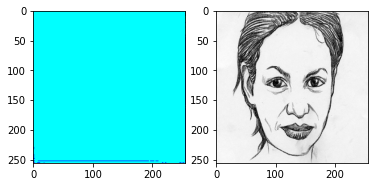

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(pred[0])
ax2.imshow(y[1]/255)

In [ ]:
model.fit(X , y,epochs=1)

In [ ]:
X[0][0].shape

In [ ]:
toto = model.predict([X[0][0].reshape((1,256,256,3)),X[0][1].reshape((1,256,256,3))])

In [ ]:
toto[1].shape

In [ ]:
plt.imshow(toto[1][0])